### Full model estimation
The following code estimates the model in full for the baseline calibration and -- as an example -- the 2024 Tax Reform.
Both demand functions are then plotted.
On my computer, this takes approximately 25 minutes to run.

In [1]:
# Packages
from IPython.display import clear_output

from types import SimpleNamespace
import numpy as np
np.set_printoptions(suppress=True) # supresses scientific notation in numpy-arrays
from scipy import optimize
from scipy import interpolate
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings
from datetime import datetime
import pandas as pd

import one_run_model as model
%load_ext autoreload
%autoreload 2

### UNIT OF ACCOUNT IN THE MODEL IS MIO DKK
d = 1000000 # Converter from DKK to mDKK

In [2]:
# PARAMETERS
par = SimpleNamespace()
par.rent = 1200*10/d # rent per m2 per year
par.uc_value = 0.01*0.8*10 # user cost per house value per year
par.uc_sqm = 300*10/d # user cost per m2 per year
par.r = ((1+0.015)**(10)-1)*0.67 # interest rate for loans, over 10 years, with 30% effective interest rate tax deduction
par.rho = (1+0.005)**(10)-1 # interest for deposits, over 10 years
par.LTI = 4/10/0.6 # 4 x yearly pre-tax income (10 years per period, tax of 40%)
par.LTV = .95 # 5% down payment rate
par.phi = 200000/d # Limit of uncollaterized loan
#par.p = 48000/d # owner price per sqm

# HOUSEHOLDS (currently, only difference between them is wage path!)
# Baseline/average agent
hh_baseline = SimpleNamespace()
hh_baseline.wage_path = [1.5,2.5,3.5,2.5,1.5]
hh_baseline.theta = [1.30,1.30,1.30,1.30,0.9] # Utility boost from owning
hh_baseline.alpha = 0.7 # Share of consumption in contemporanous utility 
hh_baseline.eta = 1.5 # CRRA utility function parameter
hh_baseline.chi = 0.2 # Strength of bequest motive
hh_baseline.beta = 0.98**10 # discounting over 10 years
hh_baseline.n = 3000 # Number of this type of agent in each generation in simulation

# Low-ish constant wage (sygeplejerske/pædagog)
hh_low = SimpleNamespace()
hh_low.wage_path = [1.5,2,2,2,2]
hh_low.theta = [1.15,1.15,1.15,1.15,0.9] # Utility boost from owning
hh_low.alpha = 0.7 # Share of consumption in contemporanous utility 
hh_low.eta = 1.5 # CRRA utility function parameter
hh_low.chi = 0.2 # Strength of bequest motive
hh_low.beta = 0.98**10 # discounting over 10 years
hh_low.n = 1000 # Number of this type of agent in each generation in simulation

# # High-earner (kandidatgrad)
hh_high = SimpleNamespace()
hh_high.wage_path = [1.5,4,4,4,4]
hh_high.theta = [1.15,1.15,1.15,1.15,0.9] # Utility boost from owning
hh_high.alpha = 0.7 # Share of consumption in contemporanous utility 
hh_high.eta = 1.5 # CRRA utility function parameter
hh_high.chi = 0.2 # Strength of bequest motive
hh_high.beta = 0.98**10 # discounting over 10 years
hh_high.n = 1000 # Number of this type of agent in each generation in simulation

# Standard demand function
df = pd.DataFrame()
w0_vec      = np.load("w0_vec.npy",allow_pickle=True)
type_vec    = np.load("type_vec.npy",allow_pickle=True)

# Price grid to loop over
price_grid = np.linspace(25000,65000,41)

In [3]:
def estimate_demand(demand_function_p):

    
    
    df = pd.DataFrame()
    df ['type'] = type_vec
    df['w0'] = w0_vec
    for p in demand_function_p:
        df[p] = np.nan
    
    for p in demand_function_p:
        
        starttime = datetime.now()
        
        par.p = p/d
        baseline_solution = model.estimate(par,hh_baseline)
        low_solution = model.estimate(par,hh_low)
        high_solution = model.estimate(par,hh_high)

        for i in df.index:
         
            w0 = df.iloc[i]['w0']
            if df.iloc[i]['type'] == 'baseline': 
                paths = model.create_paths(w0,*baseline_solution)
                demand = np.dot(paths.own_path,paths.h_path)
                if not np.isnan(demand): df.at[i,p] = demand
    
            if df.iloc[i]['type'] == 'low': 
                paths = model.create_paths(w0,*low_solution)
                demand = np.dot(paths.own_path,paths.h_path)
                if not np.isnan(demand): df.at[i,p] = demand
    
            if df.iloc[i]['type'] == 'high': 
                paths = model.create_paths(w0,*high_solution)
                demand = np.dot(paths.own_path,paths.h_path)
                if not np.isnan(demand): df.at[i,p] = demand
                
        clear_output(wait=True)
        print(p,"done in",datetime.now()-starttime)
        print("I've been running for",datetime.now()-starttimex)
    
    demand_function_q = list(df[demand_function_p].sum(axis = 0, skipna = True, numeric_only = True))
    return interpolate.interp1d(demand_function_p, demand_function_q, bounds_error=False,fill_value=None), interpolate.interp1d(demand_function_q, demand_function_p, bounds_error=False,fill_value=None)

In [4]:
# SET/CALCULATE BASELINE

starttimex = datetime.now() # Start timer

baseline_demand_q,baseline_demand_p = estimate_demand(price_grid)
    
# SET NEW TAX SYSTEM
par.uc_value = (0.01+0.005)*0.8*10 # user cost per house value per year
par.uc_sqm = 150*10/d # user cost per m2 per year
scenario1_demand_q,scenario1_demand_p = estimate_demand(price_grid)

65000.0 done in 0:00:21.381687
I've been running for 0:14:45.309733


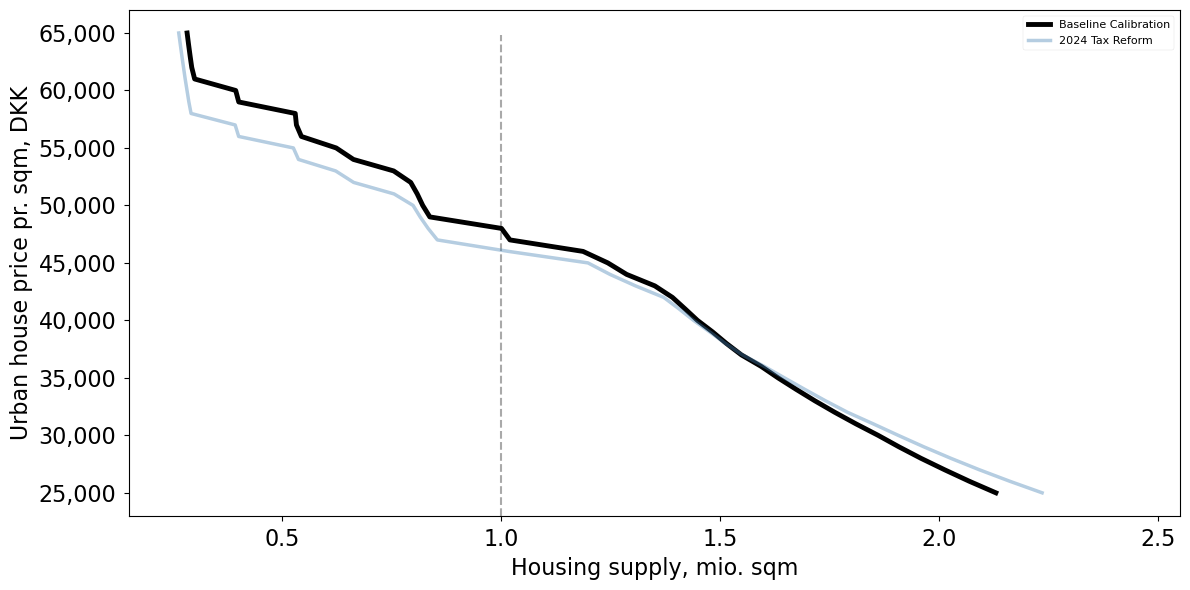

In [9]:
price_grid = np.linspace(25000,65000,41)

p_star = 48000
q_star = baseline_demand_q(p_star)


SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import matplotlib
fig, ax = plt.subplots(figsize=(12, 6))
plt.style.use(['default', 'seaborn-paper'])

ax.axvline(q_star/1000000,ymax=0.95,c='darkgray',linestyle='--',linewidth=1.5)

ax.plot(baseline_demand_q(price_grid)/1000000,price_grid, linewidth=3.5, c='black',label="Baseline Calibration") # Baseline
ax.plot(scenario1_demand_q(price_grid)/1000000,price_grid, linewidth=2.5, c='steelblue',label="2024 Tax Reform",alpha=0.4)#,linestyle=(0, (1, 1))) # Scenario 3


plt.legend()
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#ax.axhline(y=p_star,c='darkgray',xmax=0.95,linestyle='--',linewidth=1.5)
#ax.axvline(q_star2/1000000,ymax=0.95,c='firebrick',linestyle='--',linewidth=1.5)
#ax.axhline(y=p_star2,c='firebrick',xmax=0.95,linestyle='--',linewidth=1.5)
ax.set_ylabel("Urban house price pr. sqm, DKK")
ax.set_xlabel("Housing supply, mio. sqm")
ax.set_xlim([0.15, 2.55])

plt.tight_layout()
plt.draw()
#plt.savefig('Figure.pdf') # Uncomment to save